In [1]:
%matplotlib inline

In [4]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

# CPS9: Two-factor gaussian yield curve

The instantaneous interest rate is given by the dynamics
\begin{align}
    r_t &= X_t^{(1)} + X_t^{(2)} \\
    dX_t^{(i)} &= \lambda_i(\theta_i - X_t^{(i)})\,dt + \sigma_i\,dB_t^i\qquad i\in\{1,2\} \\
    X_0^{(i)} &= x_i
\end{align}
modelling the interest rate as the compound influence of two factors $X^{(1)}, X^{(2)}$.

We fix some parameters :

In [60]:
T = 15
h = 0.01
n = int(T/h)
N = int(1e4)
print("n:", n)

n: 1500


Recall forward simulation for the brownian motion: for a regular-sized grid $t_j = jT/n$,
$$
    W_{t_j} = W_{t_{j-1}} + G_j
$$
where $G_j \sim \mathcal N(0, T/n)$.

In [64]:
@nb.jit(nopython=True)
def brownian_increments(n, T, N=int(1e4)):
    """
    Compute a set of 2D brownian increments.
    
    Shape:
        - output: N * n * 2, first dimension is for Monte Carlo samples.
    """
    dt = T/n  # timestep
    incr = math.sqrt(dt)*np.random.randn(N, n, 2)
    return incr

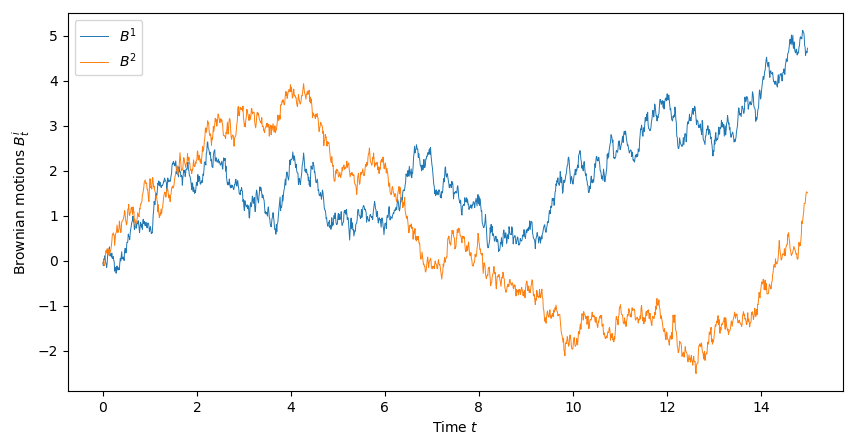

In [65]:
_test_traj_diff = brownian_increments(n, T, 1)[0]
fig, ax = plt.subplots(1, 1)
_test_traj = _test_traj_diff.cumsum(axis=0)
_test_traj_times = np.linspace(0, T, n, endpoint=False)
ax.plot(_test_traj_times, _test_traj[:,0],
        linewidth=.7, label="$B^1$"
)
ax.plot(_test_traj_times, _test_traj[:,1],
        linewidth=.7, label="$B^2$"
)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Brownian motions $B_t^i$")
ax.legend()

## Simulation of the instantaneous interest rate

We compute the factors using a recurrence relation given by Ito's formula:
$$
    X_{t_j}^{(i)} = \theta_i + \left(X_{t_{j-1}}^{(i)} - \theta_i\right)e^{-\lambda_ih}
    + \sigma U_j,\qquad i\in\{1, 2\}
$$
where the $U_j$ are defined by
$$
    U_j = \int_{t_{j-1}}^{t_j} e^{-\lambda_i(t_j-s)} \,dB_s^i \sim
    \mathcal{N}\left(0, \frac{1 - e^{-2\lambda_i h}}{2\lambda_i} \right)
$$
and are mutually independent, so can be simulated independently.

The following function involves a loop written in Python; we accelerate it using the `numba` library:

In [224]:
@nb.njit
def factors(x, thetas, lbdas, sigmas, n, T, N=int(1e4)):
    dt = T/n
    res = np.empty((N, n+1, 2))
    integral_variance_ = (1 - np.exp(-2. * lbdas * dt))/(2.*lbdas)
    integral_variance_ = integral_variance_.reshape(1, 1, 2)
    stochastic_integrals_ = np.sqrt(integral_variance_)*np.random.randn(N, n, 2)
    res[:, 0] = x
    for j in range(n):
        stoch_int_ = stochastic_integrals_[:, j]  # get stochastic integral U_j
        res[:, j+1] = thetas + (res[:, j] - thetas)*np.exp(-lbdas*dt) + sigmas*stoch_int_
    return res

We set the required parameters and test our factors function :

In [225]:
x = np.array([0.02, 0.02])
lbdas = np.array([1., 0.1])
thetas = np.array([0.05, 0.05])
sigmas = np.array([0.05, 0.05])

Text(0, 0.5, '$X_t$')

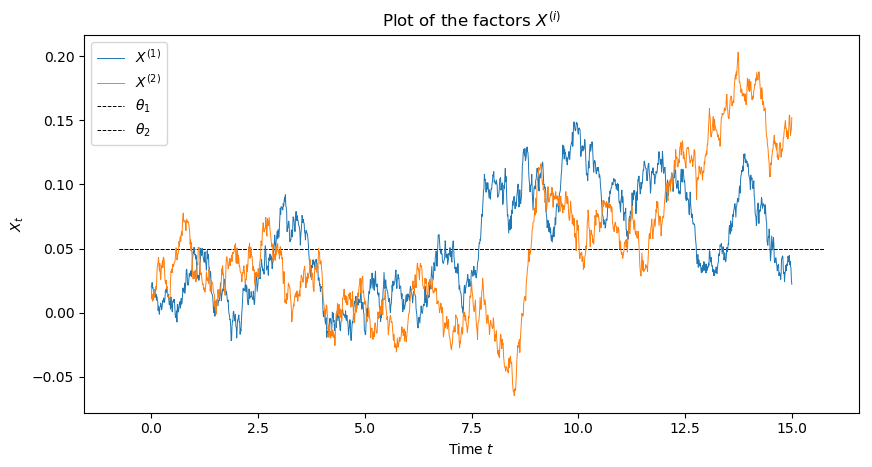

In [226]:
_test_factor_traj = factors(x, thetas, lbdas, sigmas, n, T, N=1)
_test_traj_times = np.linspace(0, T, n+1)
plt.plot(_test_traj_times, _test_factor_traj[0, :, 0],
         linewidth=.7, label='$X^{(1)}$')
plt.plot(_test_traj_times, _test_factor_traj[0, :, 1],
         linewidth=.7, label='$X^{(2)}$')
xlims = plt.xlim()
plt.hlines(thetas[0], *xlims, label=r"$\theta_1$", linestyle="--", linewidth=.7)
plt.hlines(thetas[1], *xlims, label=r"$\theta_2$", linestyle="--", linewidth=.7)
plt.legend()
plt.title("Plot of the factors $X^{(i)}$")
plt.xlabel("Time $t$")
plt.ylabel('$X_t$')

In [227]:
def interest_rate(x, thetas, lbdas, sigmas, n, T, N=int(1e4)):
    # shape N * n * 2
    factor_traj_ = factors(x, thetas, lbdas, sigmas, n, T, N)
    # shape N * n
    rate = factor_traj_.sum(axis=2)  # sum over the last dimension containing the factors
    return rate

Text(0, 0.5, 'Interest rate $r_t$')

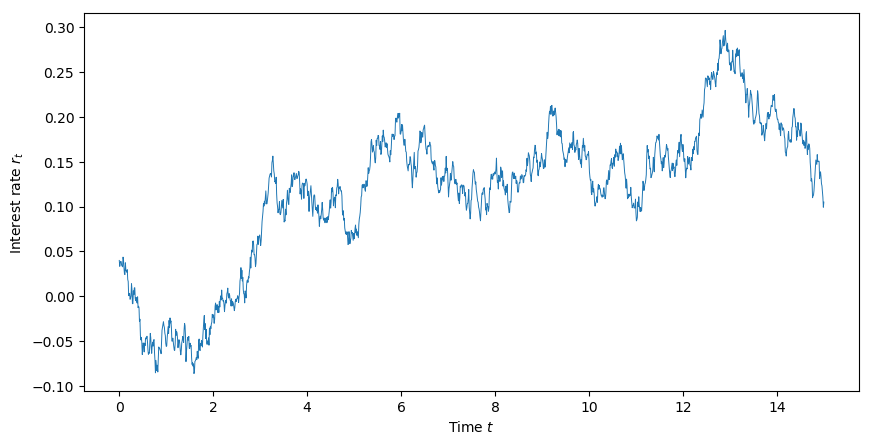

In [228]:
_test_rate_traj = interest_rate(x, thetas, lbdas, sigmas, n, T, N=1)
_test_traj_times = np.linspace(0, T, n+1)
plt.plot(_test_traj_times, _test_rate_traj[0],
         linewidth=.7)
plt.xlabel("Time $t$")
plt.ylabel('Interest rate $r_t$')

## 1.b) Monte Carlo approximation of the no-arbitrage price

A straightforward Monte Carlo estimator of the price is given by
$$
    \hat{P}_0^{n,N}(t_j) := \frac{1}{N} \sum_{\ell=1}^N \exp\left(-h\sum_{k=1}^{j} r_{t_k}^{(\ell)}\right)
$$
and an estimator of the yield at maturity is given by
$$
    \hat R_0^{n,N}(t_j) = -\frac{\ln\hat P_0^{n,N}(t_j)}{t_j}
$$

In [295]:
def monte_carlo_price(rates, n, T):
    """
    Args:
        rates (ndarray): array of the interest rate values, shape N * n
    
    Returns:
        Monte Carlo estimator of the no-arbitrage price of the ZCB, and the corresponding yields.
    """
    dt = T/n
    sums_ = np.cumsum(rates, axis=1)
    exponentials_ = np.exp(-dt * sums_)
    prices = np.mean(exponentials_, axis=0)
    tvals = np.linspace(0, T, n+1)[1:]  # remove 0
    yields = -np.log(prices[1:])/tvals
    return prices, yields

We now test the estimator by simulating the $N = 10^4$ interest rate trajectories:

In [296]:
N_mc = int(1e4)
x = np.array([0.02, 0.02])
rates = interest_rate(x, thetas, lbdas, sigmas, n, T, N=N_mc)

In [297]:
# Check the array shape
rates.shape

(10000, 1501)

In [298]:
price_sims, maturity_yields_mc = monte_carlo_price(rates, n, T)

Text(0.5, 1.0, 'ZCB price estimate as a function of time')

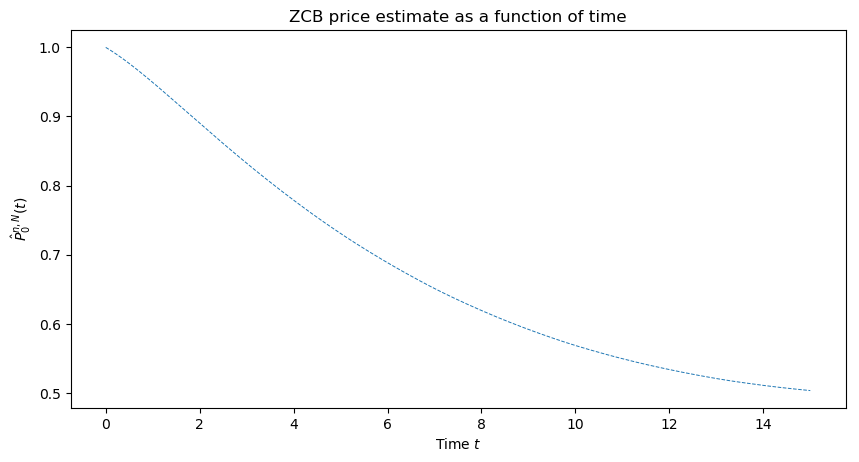

In [299]:
plt.plot(_test_traj_times, price_sims, linewidth=.7, linestyle='--')
plt.xlabel("Time $t$")
plt.ylabel("$\hat{P}_0^{n, N}(t)$")
plt.title("ZCB price estimate as a function of time")

The profile of the curve is as expected: as the maturity time $T$ approaches, the bond is less valuable.

## 1.c) Plot of the yield curve

In [300]:
def real_yield(x, thetas, lbdas, sigmas, n, T):
    dt = T/n  # timestep
    tvals = np.linspace(0, T, n+1)[1:, None]  # shape n * 1, 0 removed
    explbdaT = np.exp(-lbdas*tvals)
    lbda_T = (1. - explbdaT)/lbdas
    big_lbda_integral_ = tvals + (2/lbdas)*(explbdaT - 1) + (0.5/lbdas)* (1 - explbdaT**2)
    big_lbda_integral_ = big_lbda_integral_/(lbdas**2)
    # shape (n+1) * 2
    rhos = thetas + (x - thetas)*lbda_T/tvals - 0.5*sigmas**2/tvals*big_lbda_integral_
    return rhos.sum(axis=1)

In [301]:
maturity_yields_real = real_yield(x, thetas, lbdas, sigmas, n, T)
maturity_yields_real

array([0.04016441, 0.04032766, 0.04048975, ..., 0.04626319, 0.04624344,
       0.0462237 ])

Text(0.5, 1.0, 'ZCB yields at maturity')

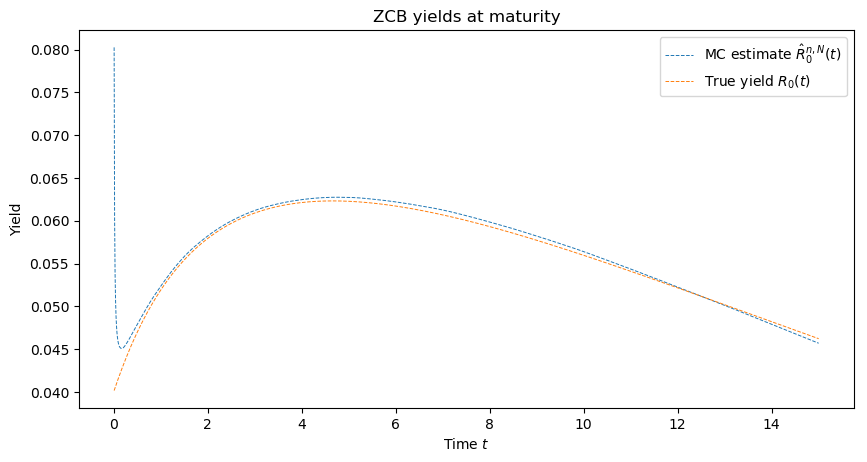

In [302]:
plt.plot(_test_traj_times[1:], maturity_yields_mc,
         linewidth=.7, linestyle='--', label="MC estimate $\hat{R}_0^{n, N}(t)$")
plt.plot(_test_traj_times[1:], maturity_yields_real,
         linewidth=.7, linestyle='--', label="True yield $R_0(t)$")
plt.xlabel("Time $t$")
plt.ylabel("Yield")
plt.legend()
plt.title("ZCB yields at maturity")

The divergence as $t$ approaches $0$ can be attributed to numerical error, as the boundedness of the ratio $\ln(P_0(t))/t$ is lost when computing the estimator.

## Varying the model parameters

### Starting value $x$

In [313]:
x = np.array([0.02, 0.02])
lbdas = np.array([1., 0.1])
thetas = np.array([0.05, 0.05])
sigmas = np.array([0.05, 0.05])

#### Fixed $x_2$

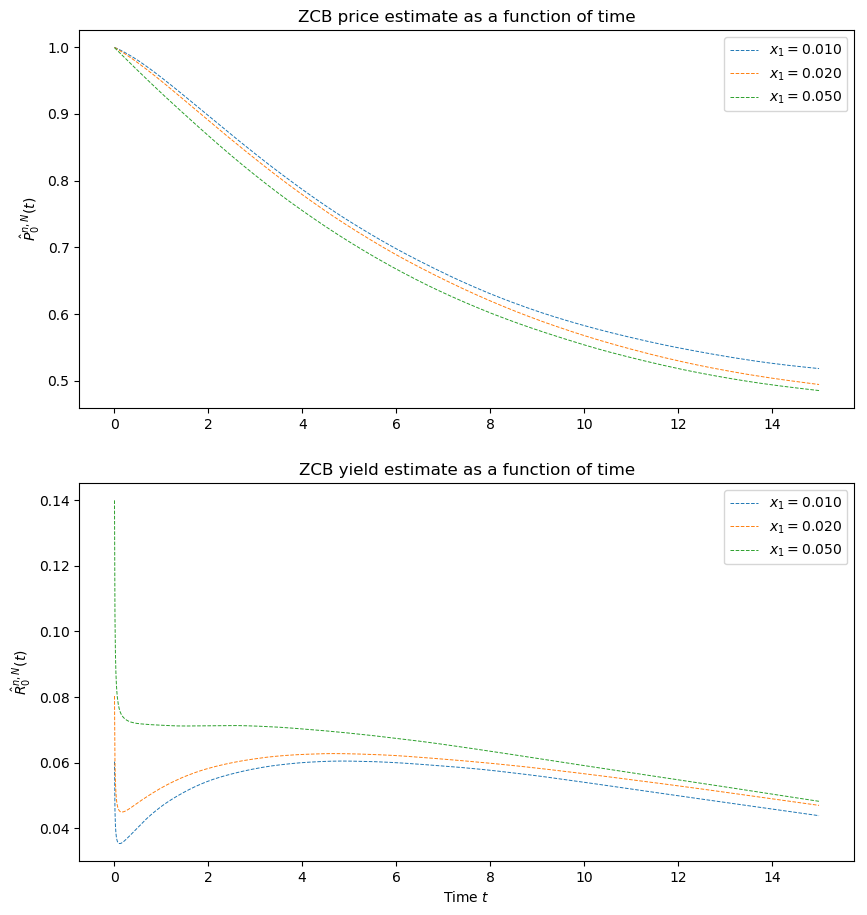

In [314]:
x2 = 0.02
prices = []
yields = []
X_RANGE = [0.01, 0.02, 0.05]
for x1 in X_RANGE:
    xn = np.array([x1, x2])
    rates = interest_rate(xn, thetas, lbdas, sigmas, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, x1 in enumerate(X_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label="$x_1={:.3f}$".format(x1))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label="$x_1={:.3f}$".format(x1))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

#### Fixed $x_1$

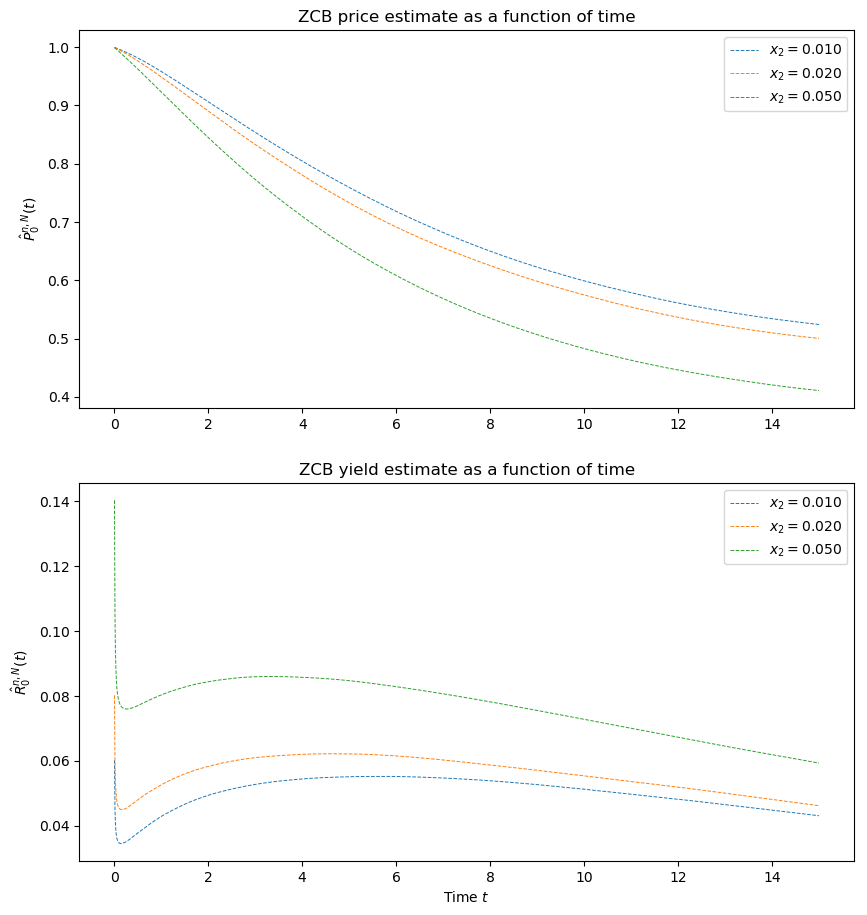

In [315]:
x1 = 0.02
prices = []
yields = []
X_RANGE = [0.01, 0.02, 0.05]
for x2 in X_RANGE:
    xn = np.array([x1, x2])
    rates = interest_rate(xn, thetas, lbdas, sigmas, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, x2 in enumerate(X_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label="$x_2={:.3f}$".format(x2))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label="$x_2={:.3f}$".format(x2))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

It seems varying the starting values $x$ changes asymptotic price and shifts the maturity curve. The effect of changing it for either factor $X^{(i)}$ is the same: the starting value of an Ornstein-Uhlenbeck process doesn't interact with the other parameters of its dynamics.

### Mean value $\theta$

In [316]:
x = np.array([0.02, 0.02])
lbdas = np.array([1., 0.1])
thetas = np.array([0.05, 0.05])
sigmas = np.array([0.05, 0.05])

#### Fixed $\theta_2$

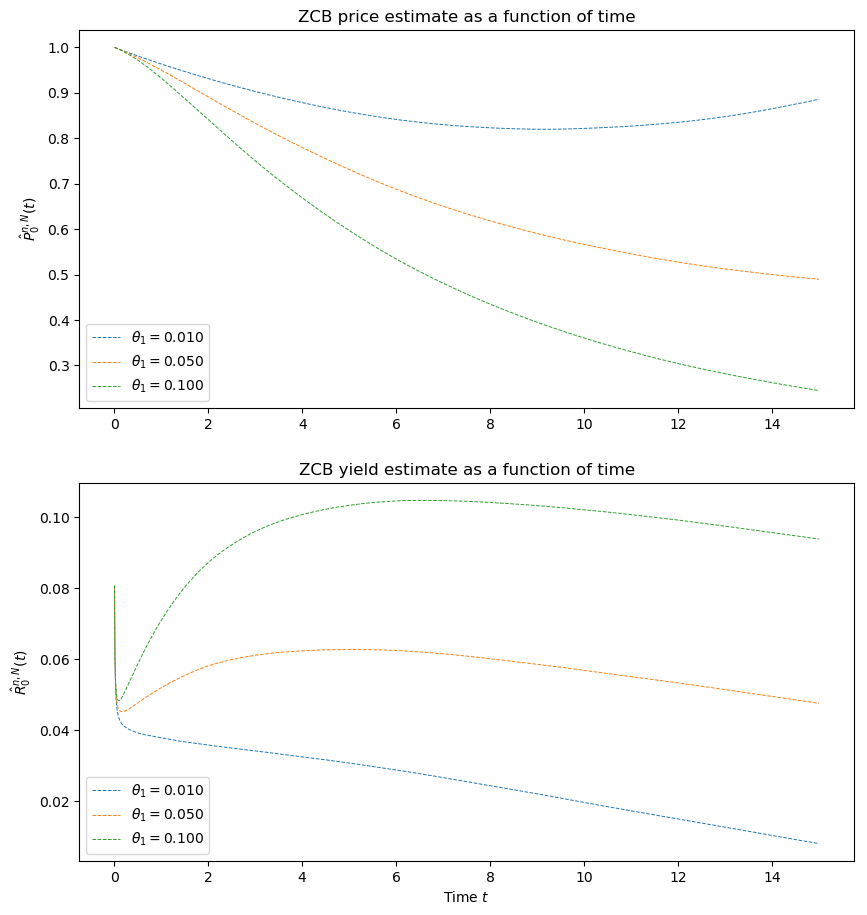

In [317]:
prices = []
yields = []
TH_RANGE = [0.01, 0.05, 0.1]
for th in TH_RANGE:
    thetn = np.array([th, thetas[1]])
    rates = interest_rate(x, thetn, lbdas, sigmas, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, th in enumerate(TH_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label=r"$\theta_1"+"={:.3f}$".format(th))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label=r"$\theta_1"+"={:.3f}$".format(th))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

#### Fixed $\theta_1$

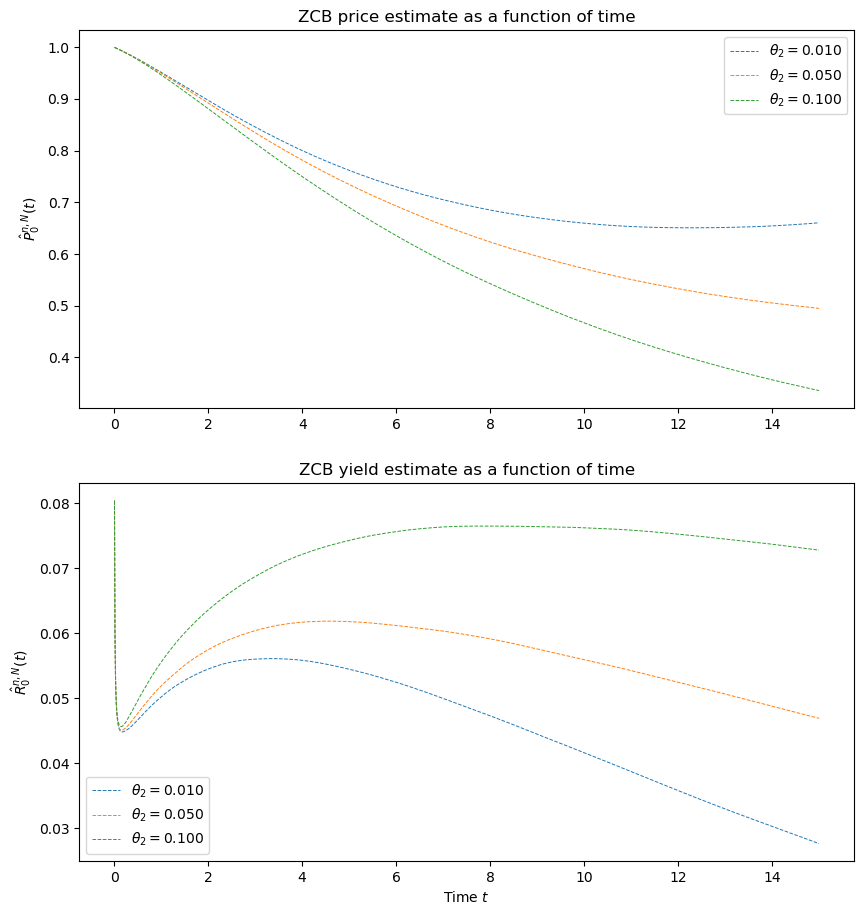

In [318]:
prices = []
yields = []
TH_RANGE = [0.01, 0.05, 0.1]
for th in TH_RANGE:
    thetn = np.array([thetas[0], th])
    rates = interest_rate(x, thetn, lbdas, sigmas, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, th in enumerate(TH_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label=r"$\theta_2"+"={:.3f}$".format(th))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label=r"$\theta_2"+"={:.3f}$".format(th))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

The higher drift $\lambda_1$ of the first factor $X^{(1)}$ means faster reversal towards the mean than the other factor. So changing the mean $\theta_1$ of the first factor has a higher impact on the ZCB price.

### Volatility $\sigma$

In [321]:
x = np.array([0.02, 0.02])
lbdas = np.array([1., 0.1])
thetas = np.array([0.05, 0.05])
sigmas = np.array([0.05, 0.05])

#### Fixed $\sigma_2$, varying $\sigma_1$

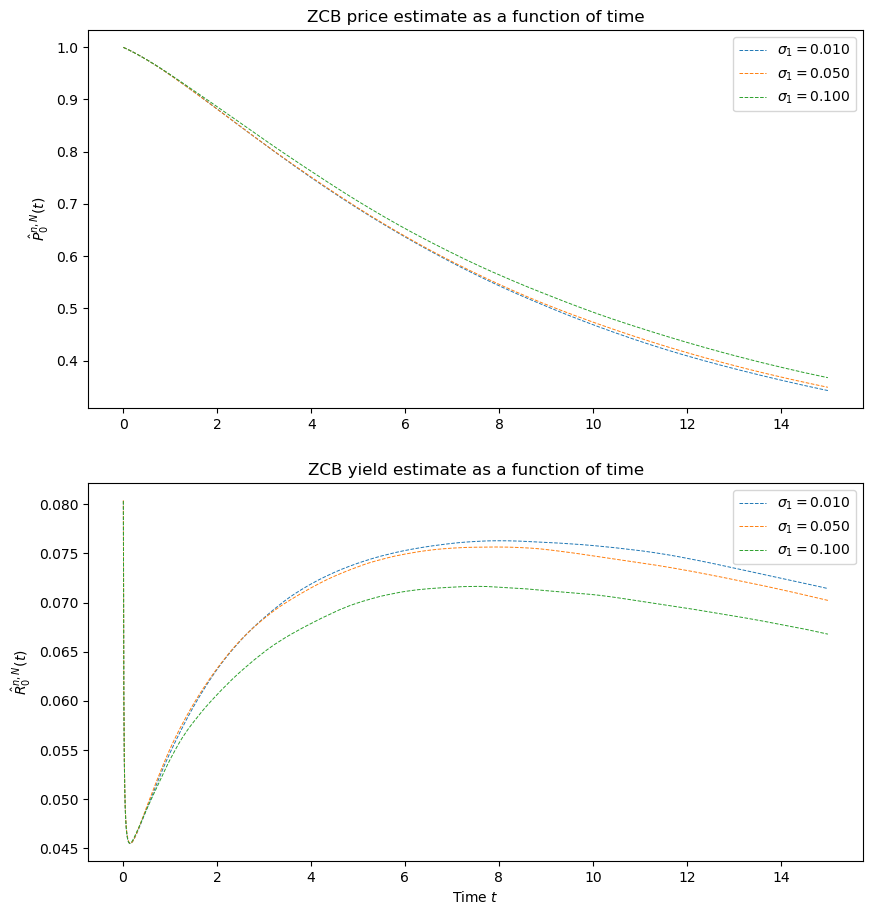

In [322]:
prices = []
yields = []
SIG_RANGE = [0.01, 0.05, 0.1]
for sgh in TH_RANGE:
    sigmn = np.array([sgh, sigmas[0]])
    rates = interest_rate(x, thetn, lbdas, sigmn, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, sgh in enumerate(SIG_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label=r"$\sigma_1"+"={:.3f}$".format(sgh))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label=r"$\sigma_1"+"={:.3f}$".format(sgh))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

The first factor $X^{(1)}$

#### Fixed $\sigma_1$, varying $\sigma_2$

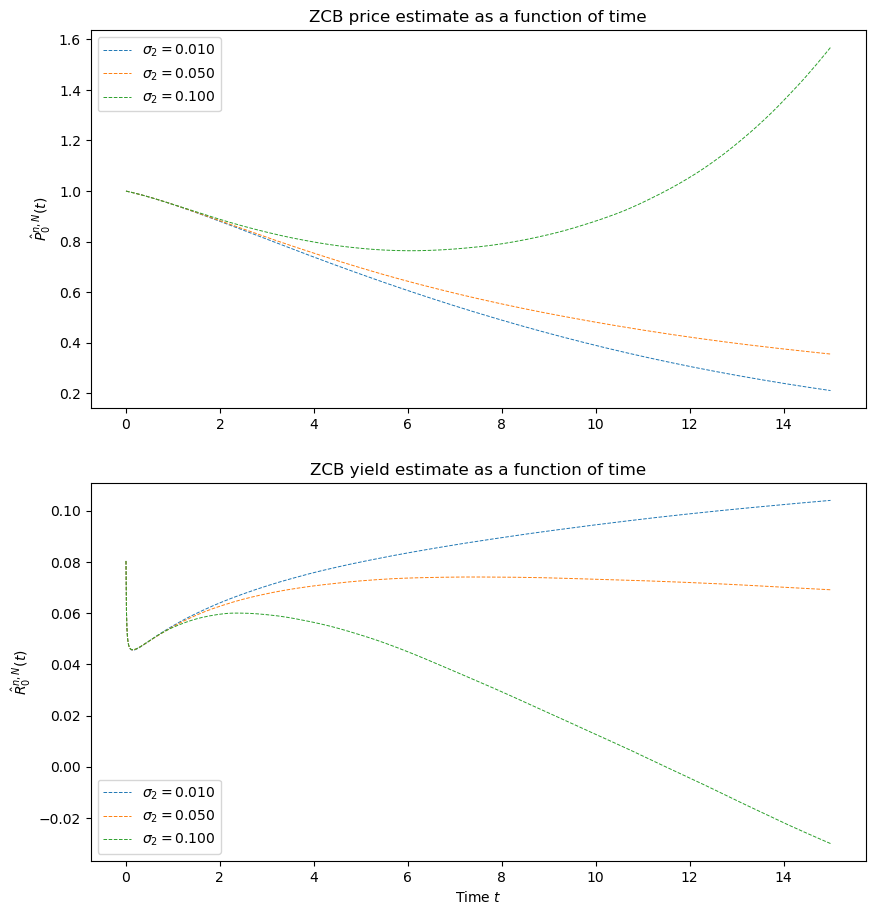

In [323]:
prices = []
yields = []
SIG_RANGE = [0.01, 0.05, 0.1]
for sgh in TH_RANGE:
    sigmn = np.array([sigmas[0], sgh])
    rates = interest_rate(x, thetn, lbdas, sigmn, n, T)
    p, y = monte_carlo_price(rates, n, T)
    prices.append(p)
    yields.append(y)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,11))
for i, sgh in enumerate(SIG_RANGE):
    p = prices[i]
    ax0.plot(_test_traj_times, p, linewidth=.7, linestyle='--',
             label=r"$\sigma_2"+"={:.3f}$".format(sgh))
    y = yields[i]
    ax1.plot(_test_traj_times[1:], y,
             linewidth=.7, linestyle='--',
             label=r"$\sigma_2"+"={:.3f}$".format(sgh))

ax0.set_ylabel("$\hat{P}_0^{n, N}(t)$")
ax0.set_title("ZCB price estimate as a function of time")
ax0.legend()
ax1.set_xlabel("Time $t$")
ax1.set_ylabel("$\hat{R}_0^{n, N}(t)$")
ax1.set_title("ZCB yield estimate as a function of time")
ax1.legend()

Since the drift parameter $\lambda_2$ for the second factor $X^{(2)}$ is lower, changing its volatility has much more impact on the rate and the ZCB price!